In [340]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import gymnasium as gym
import numpy as np
import pandas as pd
import pygame
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.spaces import Box
from gymnasium.spaces import Discrete

from paths import DATA_PATH

from torch.utils.data import Dataset, DataLoader
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

from sklearn.preprocessing import MinMaxScaler


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [22]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv')
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,580965.0
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0


In [411]:
target_df = pd.concat([
    df.high, df.low, df.volume, 
    df.open,                    
    df.close], axis=1).drop_duplicates()
target_df

,high,low,volume,open,close
0,126.41,120.90,580965.0,124.30,121.11
223,121.90,115.60,677157.0,120.00,116.60
348,117.93,115.33,390370.0,117.90,116.70
471,119.89,116.00,474415.0,116.10,119.84
649,124.00,120.05,364205.0,120.80,123.80
...,...,...,...,...,...
30126,244.46,237.01,820677.0,241.90,242.46
30245,242.90,233.00,861192.0,242.90,235.90
30367,239.23,235.90,425215.0,235.90,238.45
30483,239.70,236.52,525613.0,238.83,236.80


In [416]:
test_size = 0.22
n_samples = target_df.shape[0]

X = target_df.iloc[:, :-1]
y = target_df.iloc[:, -1]

df_train = target_df[:n_samples - int(n_samples * test_size)]
df_test = target_df[-int(n_samples * test_size):]

x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [417]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.obs_size = X.shape[1]
        self.X = torch.Tensor(X.to_numpy())
        self.y = torch.Tensor(y.to_numpy()[:,np.newaxis])
        self.index = X.index

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]
    
    
batch_size = 100


train_dataset = StockDataset(x_train, y_train)
test_dataset = StockDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, shuffle = False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle = False, batch_size=batch_size)

In [418]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("%s | Step: %d %s" % (env, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

Episode finished after 200 timesteps


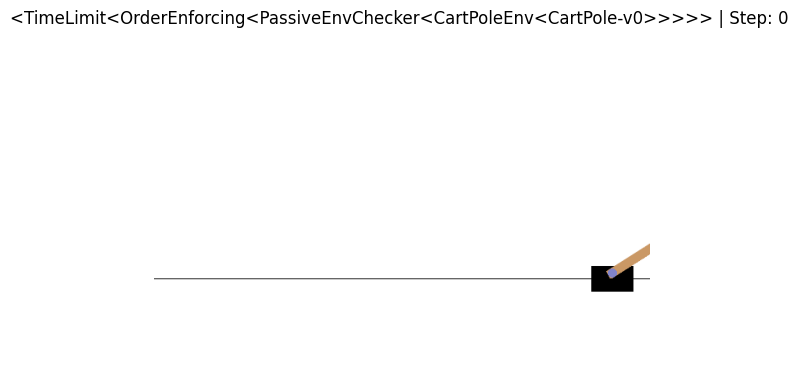

In [10]:
import gymnasium as gym

env = gym.make('CartPole-v0', render_mode='rgb_array')
observation = env.reset()
for t in range(200):
#    env.render()
    print(observation)
    show_state(env)
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    if done:
        display.clear_output(wait=True)
        print("Episode finished after {} timesteps".format(t+1))
#         break


env.close()


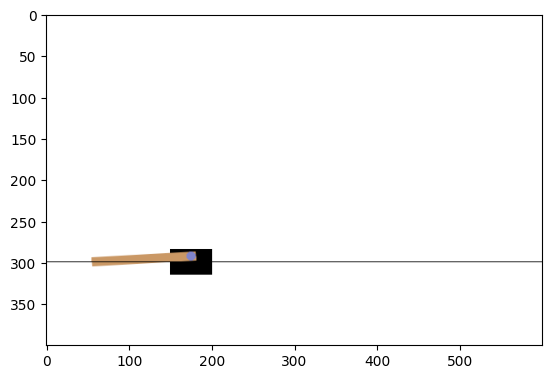

In [14]:
import gymnasium as gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v0', render_mode='rgb_array')
env.reset()
img = plt.imshow(env.render()) # only call this once
for _ in range(100):
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [295]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [434]:
class StocksEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, df, fail_difference_threshold, max_difference_for_reward=0.01, render_mode=None, size=5, fps=4):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        self._fail_difference_threshold = fail_difference_threshold
        self._max_difference_for_reward = max_difference_for_reward
    
        self._original_df = df
        
        self._scaler = MinMaxScaler()
        
        df = pd.DataFrame(self._scaler.fit_transform(df), columns=df.columns)


        X = df.iloc[:, :-1]
        self._X = X
        y = df.iloc[:, -1]
        self._y = y
        
        self._taget_column_name = self._y.name
        
                
        self._action_indent = 1e-3
        action_min = y.min() - self._action_indent
        self._action_min = action_min
        action_max = y.max() + self._action_indent
        self._action_max = action_max    

        self._initial_taget_location = y[0]
        
        feature_number = X.shape[1]

        self._dataset = StockDataset(X, y)
        
        
        #observing current state of market and news
        describe = X.describe()
        self.observation_space = spaces.Box(
            low=describe.loc['min'].to_numpy(),
            high=describe.loc['max'].to_numpy(),
            shape=(feature_number,), dtype=np.float32
        )

        # prediction of close price
#         self.action_space = spaces.Box(
#             low=-max_action_bound, 
#             high=+max_action_bound,
#             dtype=np.float32,
#         )
        # prediction to buy or to sell relatively
        self.action_space = spaces.Discrete(3)
        target_std = self._y.std()
        shift = target_std / 10
        self._action_to_shift = {
            0: np.array([0]),
            1: shift,
            2: -shift,
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None

    def _get_obs(self):
        features, target = self._dataset[self._current_dataset_idx]
        return features

    def _get_info(self):
        return self._current_dataset_idx
    

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self._agent_history = []

#         self._agent_location = self.np_random.integers(self._obs_min, self._obs_max, size=1, dtype=np.float32)
        self._agent_location = np.array([self._initial_taget_location])

        self._target_location = np.array([self._initial_taget_location])
        
        self._current_dataset_idx = 0

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        self._reward_count = 0

        return observation, info

    def step(self, action):
        shift = self._action_to_shift[action]
        
        self._agent_location = np.clip(
            self._agent_location + shift, self._action_min, self._action_max
        )
        
        self._agent_history.append(self._agent_location)

        

        target = self._y[self._current_dataset_idx]

        agent_target_difference = np.abs(self._agent_location - target)

        reward = 1 if agent_target_difference < self._max_difference_for_reward else 0
        
        self._reward_count += reward
        
        terminated = (
            (self._current_dataset_idx >= len(self._dataset) - 1)
            or
            (agent_target_difference > self._fail_difference_threshold)
        )
    
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        
        self._current_dataset_idx += 1
        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _inv_transform(self, data):
        scaler = self._scaler
        dummy = pd.DataFrame(np.zeros((len(data), len(self._original_df.columns))), columns=self._original_df.columns)
        dummy[self._taget_column_name] = data
        return scaler.inverse_transform(dummy)

    def _render_frame(self):
        target = self._y[:self._current_dataset_idx]
        agent = np.array(self._agent_history).flatten()

        plt.figure(3)
        plt.clf()
        plt.cla()
        plt.plot(target, label='target')
        plt.plot(agent, label='agent')
        
        plt.title("%s | Step: %d | Reward: %d" % (env, self._current_dataset_idx, self._reward_count))
#         plt.ylim((target.min()-0, target.max()+0))
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


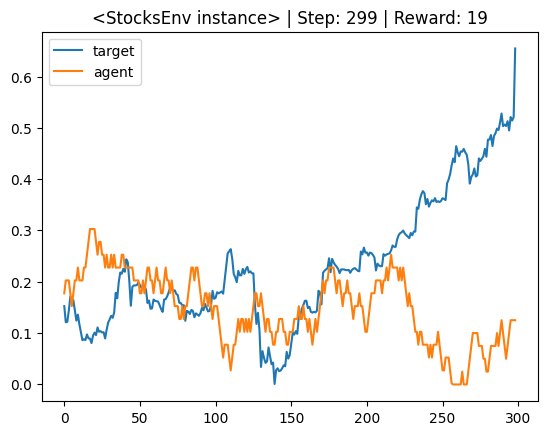

In [435]:
env = StocksEnv(target_df, fail_difference_threshold=0.5, render_mode="rgb_array")


observation, info = env.reset(seed=42)


for i in range(1000000):
    action = env.action_space.sample()
#     action = 0
    
    observation, reward, terminated, truncated, info = env.step(action)
    if i % 1000 == 0:
#         env.render()
        pass

    if terminated or truncated:
        env.render()
        observation, info = env.reset()
        break


env.close()

In [436]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [437]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [471]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


env = StocksEnv(target_df, fail_difference_threshold=0.2, max_difference_for_reward=0.05, render_mode="rgb_array")


n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []
rewards = []


def plot_durations(show_result=False):
    fig, axs = plt.subplots(2, 1, figsize=(10,5))
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    eps_plt = axs[0]
    if show_result:
        eps_plt.set_title('Result')
    else:
        plt.clf()
        eps_plt.title('Training...')

#     eps_plt.set_xlabel('Episode')
    eps_plt.set_ylabel('Duration')
    eps_plt.plot(durations_t.numpy(), label='durations')
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        eps_plt.plot(means.numpy(), label='mean durations')
    
    rewards_plt = axs[1]
    rewards_plt.plot(rewards, label='reward', c='r')
    rewards_plt.set_xlabel('Episode')
    rewards_plt.set_ylabel('Reward')
    fig.legend()
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    # Transpose the batch
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

if torch.cuda.is_available():
    num_episodes = 6000
else:
    num_episodes = 5000

/Users/ruslansirazhetdinov/Documents/MIPT/Учеба/nlpystocks/.venv.nosync/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


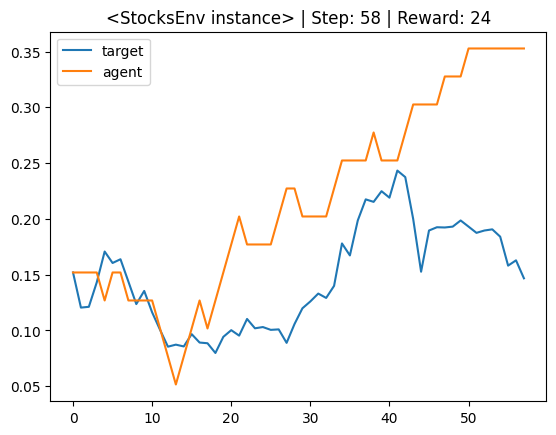

EPISODE 2178
LAST FAIL 57


KeyboardInterrupt: 

In [472]:
for i_episode in range(num_episodes):
    print('EPISODE', i_episode)
    print('LAST FAIL', t)
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    reward_count = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward_count += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if (t+1) % 1000 == 0:
            print(t)
            env.render()

        if done:
            episode_durations.append(t + 1)
            rewards.append(reward_count)
#             plot_durations(show_result=True)
            env.render()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

<Figure size 640x480 with 0 Axes>

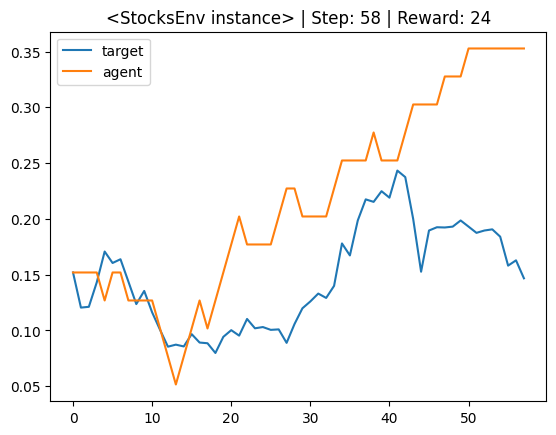

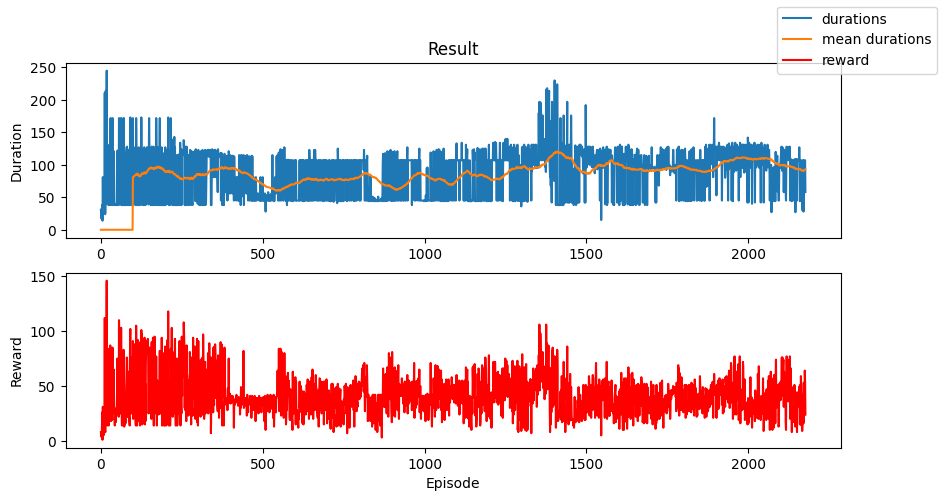

<Figure size 640x480 with 0 Axes>

In [473]:
plot_durations(show_result=True)